In [1]:
import symmray as sr
import quimb.tensor as qtn

In [2]:
symmetry = "U1"

Lx = 4
Ly = 4
D = 6


def site_charge(site):
    # put two fermions on odd sites -> half filling
    return 2 * ((site[0] + site[1]) % 2)


peps = sr.PEPS_fermionic_rand(
    symmetry=symmetry,
    Lx=Lx,
    Ly=Ly,
    bond_dim=D,
    seed=42,
    phys_dim=4,
    site_charge=site_charge,
)

print(peps.arrays[0])

U1FermionicArray(ndim=3, charge=0, indices=[
    (6 = 1+1+1+1+1+1 : +[-2,-1,0,1,2,3])
    (6 = 1+1+1+1+1+1 : +[-2,-1,0,1,2,3])
    (4 = 1+2+1 : +[0,1,2])
], num_blocks=12, backend=numpy, dtype=float64)


In [3]:
terms = sr.ham_fermi_hubbard_from_edges(
    symmetry=symmetry,
    edges=tuple(peps.gen_bond_coos()),
    t=1.0,
    U=8.0,
    mu=0.0,
)
ham = qtn.LocalHam2D(Lx, Ly, terms)

print(next(iter(terms.values())))

U1FermionicArray(ndim=2, charge=0, indices=[
    (16 = 1+4+6+4+1 : +[0,1,2,3,4])
        0 ; (1) : [(0, 0)]
        1 ; (2+2) : [(0, 1),(1, 0)]
        2 ; (1+4+1) : [(0, 2),(1, 1),(2, 0)]
        3 ; (2+2) : [(1, 2),(2, 1)]
        4 ; (1) : [(2, 2)]
    (16 = 1+4+6+4+1 : -[0,1,2,3,4])
        0 ; (1) : [(0, 0)]
        1 ; (2+2) : [(0, 1),(1, 0)]
        2 ; (1+4+1) : [(0, 2),(1, 1),(2, 0)]
        3 ; (2+2) : [(1, 2),(2, 1)]
        4 ; (1) : [(2, 2)]
], num_blocks=5, backend=numpy, dtype=float64)


In [4]:
su = qtn.SimpleUpdateGen(
    peps,
    ham,
    # setting a cutoff is important to turn on dynamic charge sectors
    gate_opts=dict(cutoff=1e-12),
    second_order_reflect=True,
    # SimpleUpdateGen compute cluster energies by default
    # which might not be accurate
    compute_energy_every=10,
    compute_energy_opts=dict(max_distance=1),
    compute_energy_per_site=True,
)

In [5]:
# (this simple update scheme is likely not optimal)
# su.evolve(1, tau=0.1)
su.evolve(20 * Lx * Ly, tau=0.1)

n=320, tau=0.1000, energy~-0.399576: 100%|##########| 320/320 [02:58<00:00,  1.79it/s]


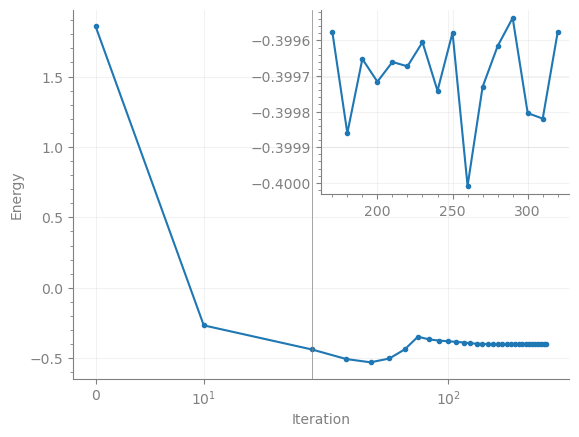

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Iteration', ylabel='Energy'>)

In [6]:
su.plot()

In [7]:
gs = su.get_state()

Check energy properly with boundary contraction and increasing $\chi$.

In [8]:
gs.compute_local_expectation(
    ham.terms, normalized=True, max_bond=16,
) / gs.nsites

-0.4155638879347775

In [9]:
gs.compute_local_expectation(
    ham.terms, normalized=True, max_bond=32,
) / gs.nsites

-0.4153614954277079

In [10]:
gs.compute_local_expectation(
    ham.terms, normalized=True, max_bond=64,
) / gs.nsites

-0.4153314860583426